In [26]:
import root_pandas as rp
import pandas as pd
import ROOT
from ROOT import TVector3, TRandom, TMath
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import torch



In [27]:
# Specify location of data file
data_loc = '/Users/majdghrear/data/e_dir_fit'

# Load the processed data
df = pd.read_pickle(data_loc+'/3D_processed_data/processed_recoils_0.pk')

df.columns

Index(['x', 'y', 'z', 'dir', 'offset'], dtype='object')

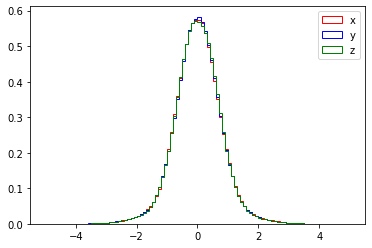

In [28]:
# Extract and combine all spacial info
all_x = np.concatenate(df.x)
all_y = np.concatenate(df.y)
all_z = np.concatenate(df.z)

# Plot spacial info to ensure dataset is isotropic
plt.figure()
datax = plt.hist(all_x, bins=100, density=True, range =(-5,5), histtype='step',color='r',label ='x')
datay = plt.hist(all_y, bins=100, density=True, range =(-5,5), histtype='step',color='b',label ='y')
dataz = plt.hist(all_z, bins=100, density=True, range =(-5,5), histtype='step',color='g',label ='z')
plt.legend()


True recoil direction:  [-0.4921258579655481, 0.49545470224164423, 0.7157770448598619]


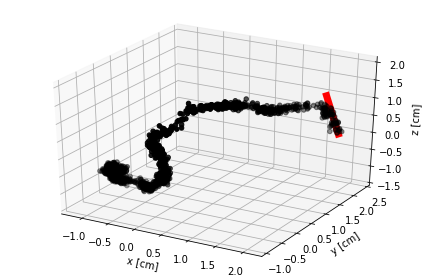

In [29]:
# Visualize a recoil

#select index of recoil to visualize
i = 12

# This function makes all axis have the same range
def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

# Obtain x,y,z and true recoil direction info
x_i = df.iloc[i]['x']
y_i = df.iloc[i]['y']
z_i = df.iloc[i]['z']
dir_i = df.iloc[i]['dir']
offset_i = df.iloc[i]['offset']

# Print the recoil direction
print("True recoil direction: ", dir_i)


# plot full recoil
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x_i, y_i, z_i, c='k', marker='o')

# Add red line for true direction
dir_head = np.array(dir_i) - np.array(offset_i)
dir_tail = -1.0*np.array(offset_i)
ax.plot3D([dir_tail[0],dir_head[0]], [dir_tail[1],dir_head[1]], [dir_tail[2],dir_head[2]], c='r',linewidth=7)

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')
plt.tight_layout()
axisEqual3D(ax)

In [30]:
# Pixelize the recoil

# x/y/z length being kept in cm
eff_l = 2.5

# Voxel size in cm
vox_l = 0.1


#number of pixels along 1 dim
Npix = round(eff_l*2/vox_l) 


# Create grid for image
grid = np.zeros((Npix,Npix,Npix,1))

missing = 0

# loop through recoil
for x,y,z in zip(df.iloc[i]['x'],df.iloc[i]['y'],df.iloc[i]['z']):
    
    #obtain index corresponiding to position
    x_ind = int((x+eff_l)/vox_l)
    y_ind = int((y+eff_l)/vox_l)
    z_ind = int((z+eff_l)/vox_l)
    
    if 0<=x_ind<Npix and 0<=y_ind<Npix and 0<=y_ind<Npix:
        grid[x_ind,y_ind,z_ind,0] += 1
        
    else:
        missing += 1
        

print("Amount of missing charge: ", missing) 

Amount of missing charge:  0


In [31]:
# Transform initial direction to pixel coords
head_x = (dir_head[0]+eff_l)/vox_l
head_y = (dir_head[1]+eff_l)/vox_l
head_z = (dir_head[2]+eff_l)/vox_l

tail_x = (dir_tail[0]+eff_l)/vox_l
tail_y = (dir_tail[1]+eff_l)/vox_l
tail_z = (dir_tail[2]+eff_l)/vox_l

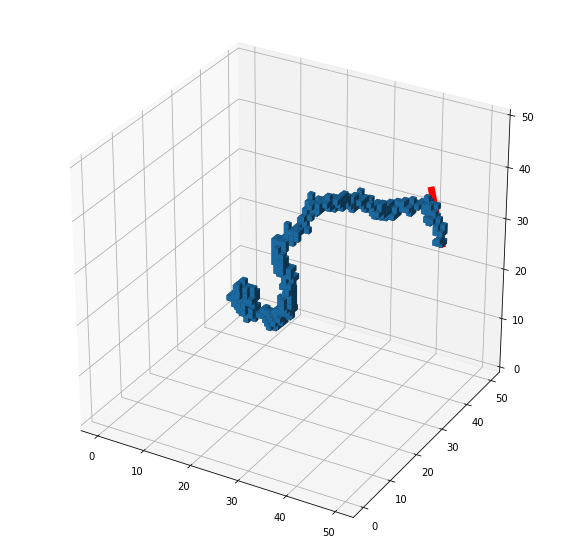

In [32]:
# Plot pixelized recoil along with true direction

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

#w=plt.axis('off')
e=ax.voxels(grid[:,:,:,0])

# Plot true direction
ax.plot3D([tail_x,head_x], [tail_y,head_y], [tail_z,head_z], c='r',linewidth=7)



In [33]:
# Pixelize dataframe
# I only do it for one file now

# x/y/z length being kept in cm in cm
eff_l = 3.0
# voxel size in cm
vox_l = 0.05

#number of pixels along 1 dim
Npix = round(eff_l*2/vox_l) 


labels = []
sparse_tensors = []
offsets = []
dim = (Npix,Npix,Npix,1)

# Record how many recoils are ommitted because they are note within the fiducial volume 
dropped = 0

for index, row in df.iterrows():
    
    # If recoil escapes fiducial area, skip it
    if np.max(row['x']) >= eff_l or np.min(row['x']) < -eff_l or np.max(row['y']) >= eff_l or np.min(row['y']) < -eff_l or np.max(row['z']) >= eff_l or np.min(row['z']) < -eff_l:
        dropped += 1
        continue
            
    # Initialize empty dense tensor
    voxelgrid = np.zeros(dim).astype('uint8')
    
    # Loop the x, y, z positions in the recoil and fill in the dense tensor
    for x,y,z in zip(row['x'],row['y'],row['z']):
        voxelgrid[int((x+eff_l)/vox_l)][int((y+eff_l)/vox_l)][int((z+eff_l)/vox_l)][0] += 1
        
    # Convert to pytorch tensor
    voxelgrid = torch.tensor(voxelgrid)
    # Convert to sparse pytorch tensor
    vg = voxelgrid.to_sparse()
    
    # Store sparse tensor and corresponding label 
    sparse_tensors += [vg]
    labels += [row['dir']] 
    offsets += [row['offset']]


# Save sparse tensors and labels
torch.save( sparse_tensors, data_loc+'/testing/sparse_recoils_0.pt')
np.savetxt(data_loc+'/testing/labels_0.txt',labels)
np.savetxt(data_loc+'/testing/offsets_0.txt',offsets)

print(dropped, " files have been ommitted")

1956  files have been ommitted


In [34]:
# Load sparse tensors and labels
# The offsets are only used in the exploratory code to visually see that the true direction is correct
X = torch.load(data_loc+'/testing/sparse_recoils_0.pt')
Y = np.loadtxt(data_loc+'/testing/labels_0.txt').tolist()
offsets = np.loadtxt(data_loc+'/testing/offsets_0.txt').tolist()


In [35]:
# Break into train and test sets

# X is the input voxilized track
X_train = X[:3000]
X_test = X[3000:]

# Y is the true direction which the CNN must predict
Y_train = Y[:3000]
Y_test = Y[3000:]

# This is the C.O.M offset, it is only used here so that we can visualize the true direction along with the recoil
offset_train = offsets[:3000]
offset_test = offsets[3000:]

print(len(X_test),len(X_train))



5044 3000


In [40]:
# The following function is used to serve up both train and validation data in batches.
def data_generator(X, Y, off, batchsize):
    N = len(X)
    while True:
        # We must use a for loop here as a list of sparse tensors may not be converted into an array
        indices = np.random.randint(low=0, high=N, size=(batchsize,))
        X1 = np.array( [(X[index].to_dense()).detach().numpy() for index in indices] )
        Y1 =np.array( [Y[index] for index in indices] )
        off1 = np.array( [off[index] for index in indices] )
            
        # yield tensors and directions
        yield X1, Y1, off1
        
# Create generators.
batchsize  = 200
data_train = data_generator(X_train, Y_train, offset_train, batchsize)
data_valid = data_generator(X_test, Y_test, offset_test, batchsize)

In [41]:
# Collect several batches from grenerator
# I want to make this as fast as possible

for i in range(100):
    inputs, outputs, coms = data_train.__next__()

    inputs.shape

# If batchsize is 200, it take ~0.366s to serve up a batch. Previously, training a 3D CNN took ~8s per step, so this a small contribution

In [45]:
# draw another batch from the generator
inputs, outputs, coms = data_train.__next__()
print(inputs.shape)
print(outputs.shape)

(200, 120, 120, 120, 1)
(200, 3)


In [46]:
# Plot true recoil direction


dir_head = np.array(outputs[0]) - np.array(coms[0])
dir_tail = -1.0*np.array(coms[0])

head_x = (dir_head[0]+eff_l)/vox_l
head_y = (dir_head[1]+eff_l)/vox_l
head_z = (dir_head[2]+eff_l)/vox_l

tail_x = (dir_tail[0]+eff_l)/vox_l
tail_y = (dir_tail[1]+eff_l)/vox_l
tail_z = (dir_tail[2]+eff_l)/vox_l

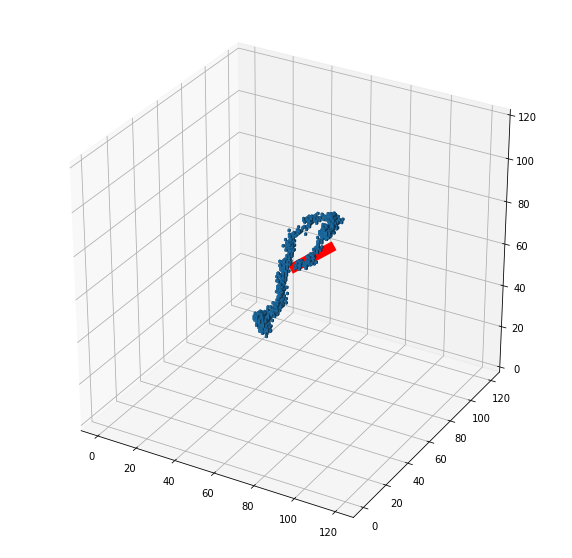

In [47]:
# Plot pixelized recoil

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

#w=plt.axis('off')
ax.plot3D([tail_x,head_x], [tail_y,head_y], [tail_z,head_z], c='r',linewidth=10)
e=ax.voxels(inputs[0][:,:,:,0])


